In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import warnings
warnings.filterwarnings('ignore')
import sys

In [3]:
pd.set_option('display.max_columns',10000)
pd.set_option('display.max_rows',10000)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df=pd.read_csv('smart_phone.csv')

In [5]:
df=df.drop(columns = ['Unnamed: 0'],axis='columns')
df.drop(['Android_version','Name','Rating','Spec_score'],axis=1,inplace=True)
df['Processor_']=df['Processor_'].replace('sc9863a','unisoc')
df=df[~df.Processor_.isin(['octa','other'])]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 1369
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Dual Sim              1364 non-null   int64  
 1   VoLTE                 1364 non-null   int64  
 2   5G                    1364 non-null   int64  
 3   Vo5G                  1364 non-null   int64  
 4   Ram                   1364 non-null   float64
 5   Battery               1364 non-null   int64  
 6   Display               1364 non-null   float64
 7   Foldable Display      1364 non-null   int64  
 8   Dual Display          1364 non-null   int64  
 9   External_Memory       903 non-null    float64
 10  Price                 1364 non-null   int64  
 11  company               1364 non-null   object 
 12  Inbuilt_memory        1346 non-null   float64
 13  fast_charging         1280 non-null   float64
 14  Water Drop Notch      1364 non-null   int64  
 15  with Punch Hole       1364

### missing value in External memory and inbuilt memory and fast charging and processor series

In [7]:
#removing outliear
df=df[df.Price<200000]
df=df[df.Battery<7000]

In [8]:
df.External_Memory.fillna(0,inplace=True)
fast_c=df.groupby('company')['fast_charging'].agg(lambda x: stats.mode(x)).apply(lambda x : x[0]).to_dict()
for i in fast_c:
    df.loc[df.company==i,'fast_charging']=df.loc[df.company==i,'fast_charging'].fillna(fast_c[i])
df=df.dropna()

In [9]:
# convert small company in other
temp=df.company.value_counts().reset_index()
l=temp[temp['count']<15]['company'].to_list()
df.company.replace(l,'other',inplace=True)

In [10]:
# add new column  PPI
df['PPI']=np.sqrt(df['V px']**2+df['H px']**2)/df.Display
df=df.drop(['V px','H px','Display'],axis=1)

In [11]:
col=df.columns.to_list()
n_col=['Battery','Price','fast_charging','Primary_rear_camera','Primary_front_camera','PPI']
for r in n_col:
    col.remove(r)

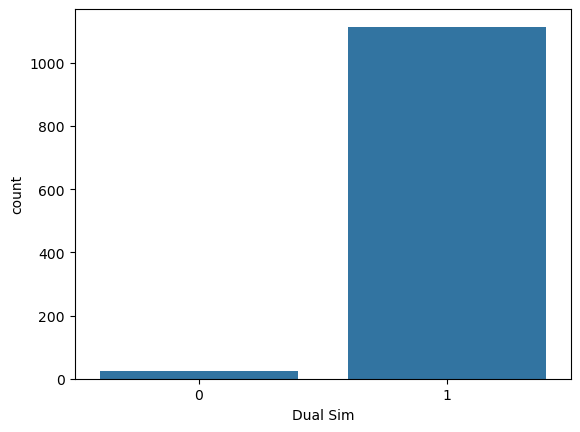

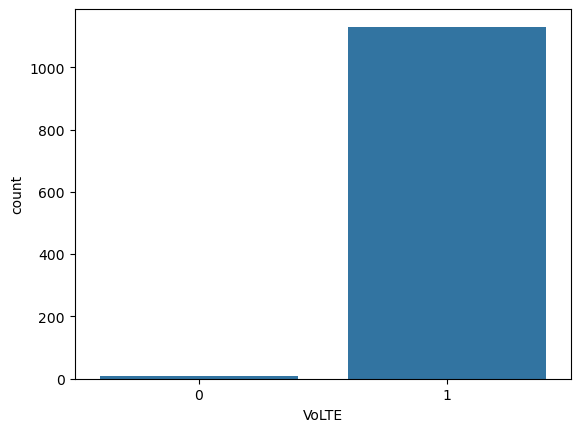

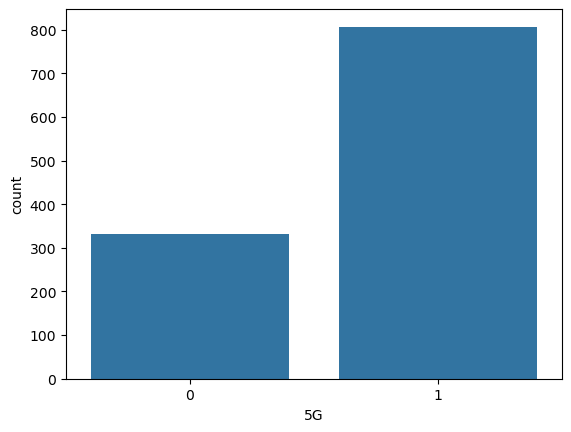

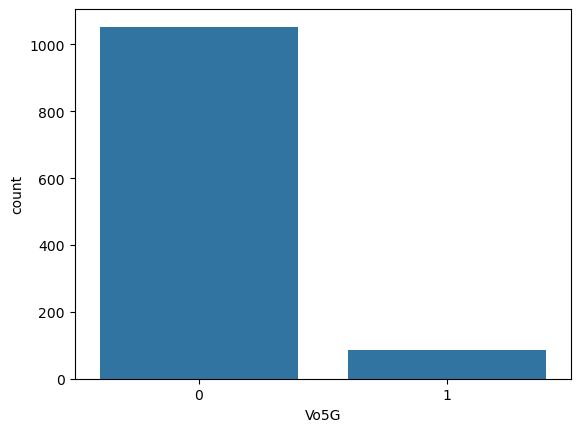

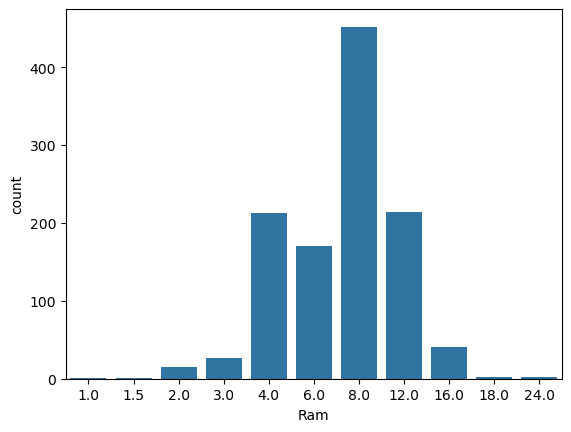

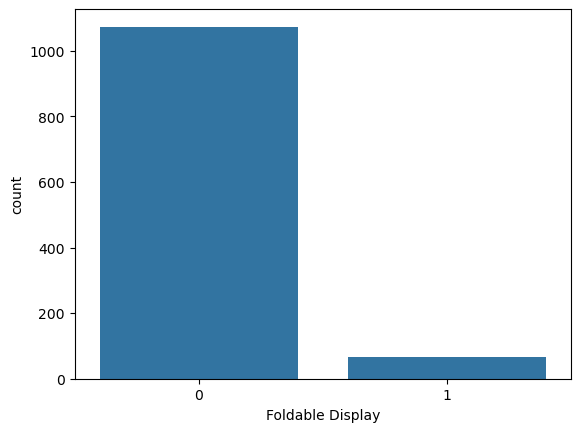

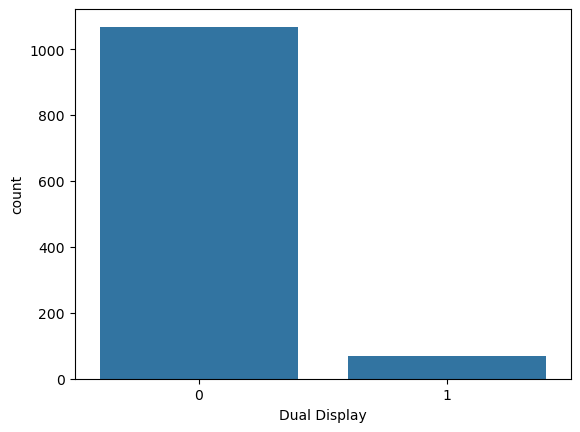

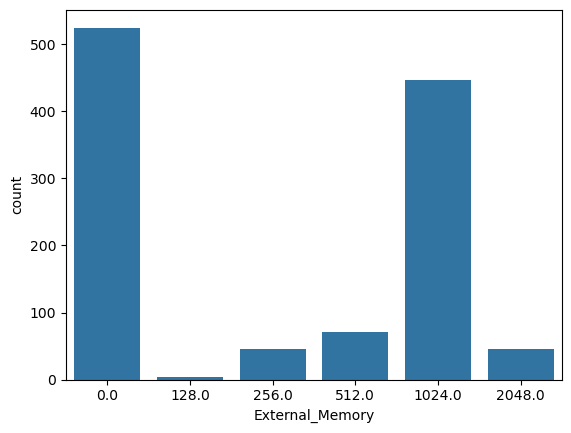

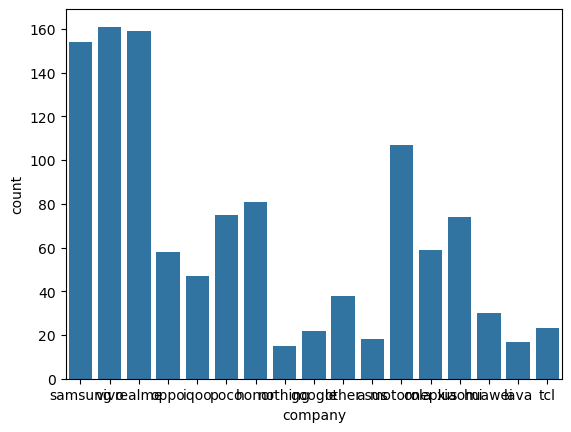

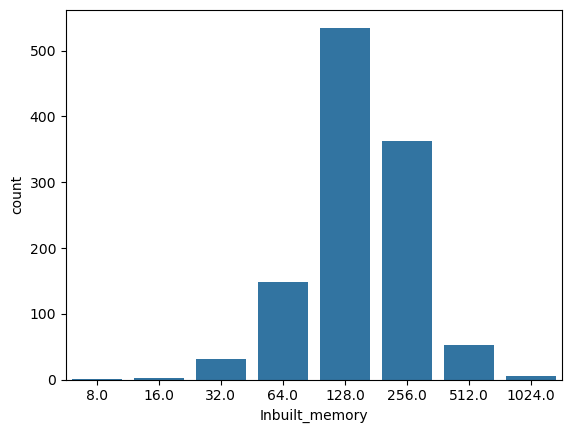

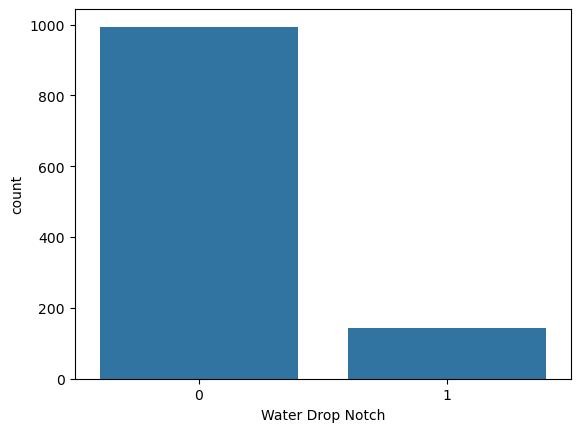

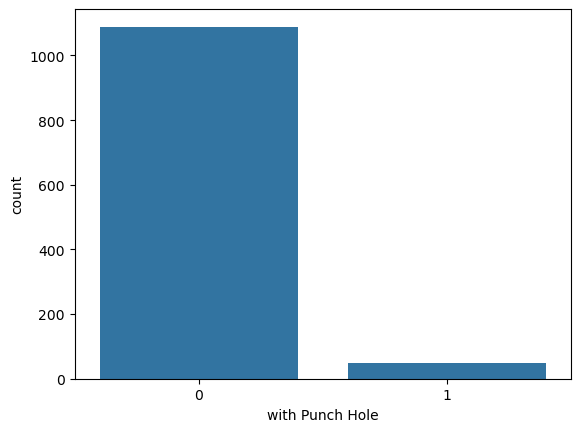

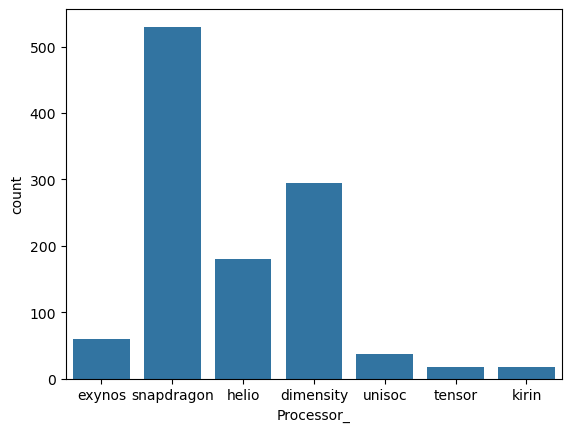

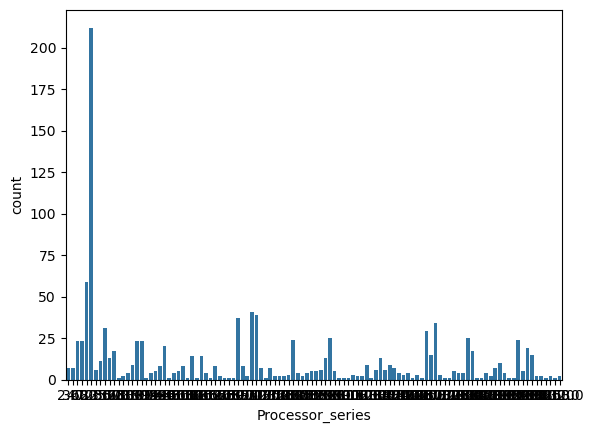

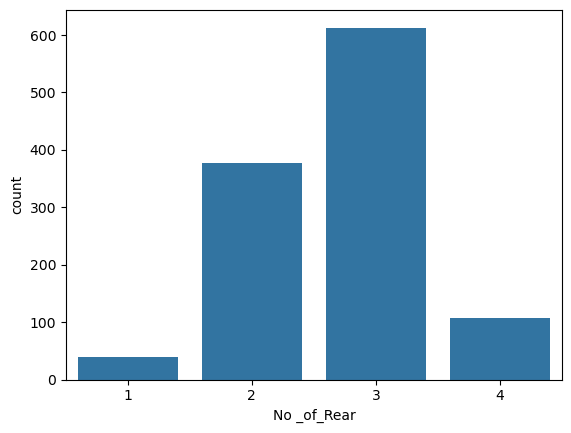

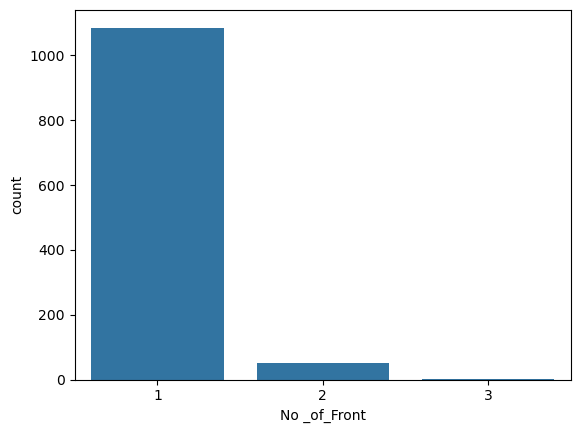

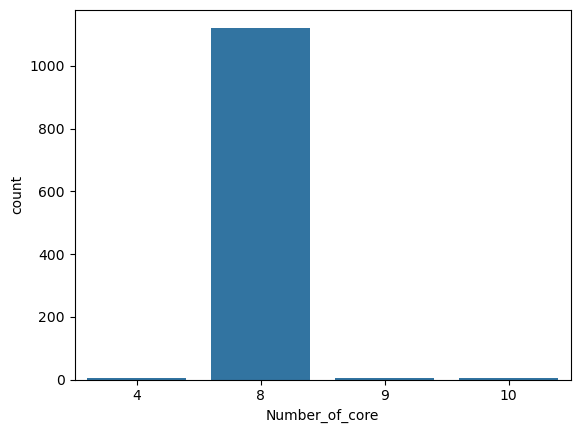

In [12]:
for i in col:
    sns.countplot(df,x=i)
    plt.show()
# Most of phones have dual sim
# all most have volte
# 70 % phone has 5g
# 5 % phone has vo5g
# Most of having 8 GB ram
# Most of phones have 128 GB and 256 GB
# 50% comes with sanpdragon
# 60% of phones have triple rear camera 
# 80% of phones come with a single front camera
# Processers come with 8-core

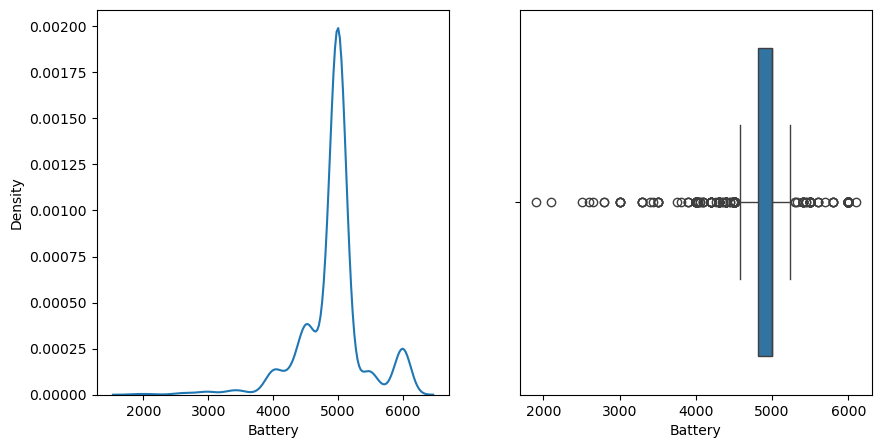

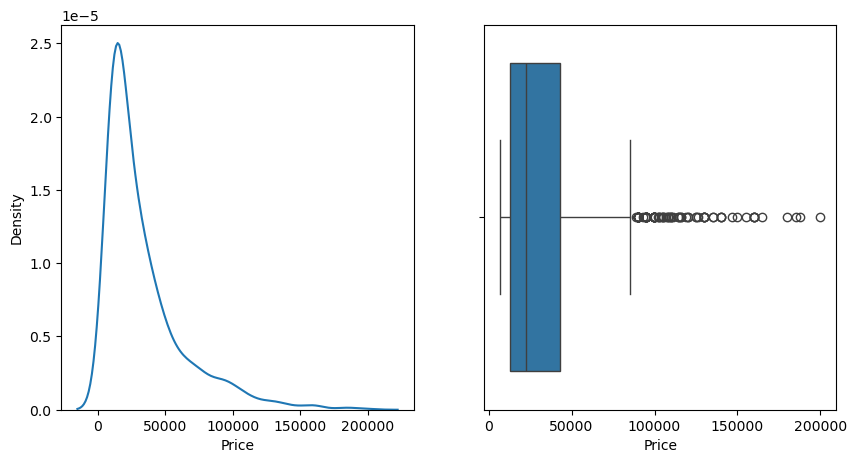

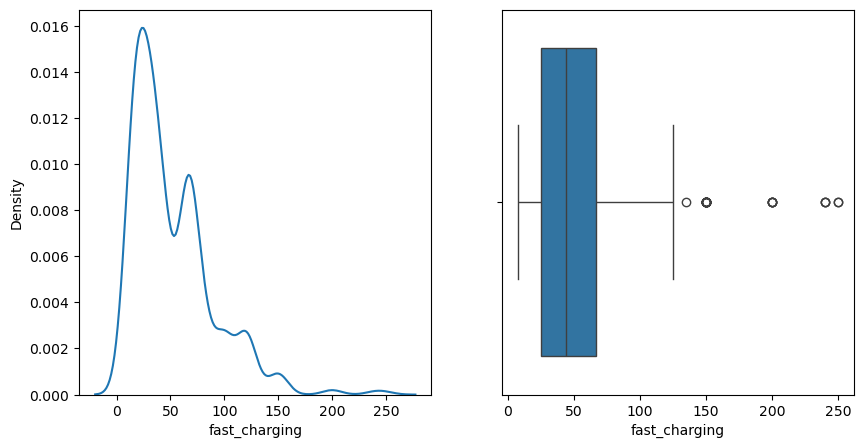

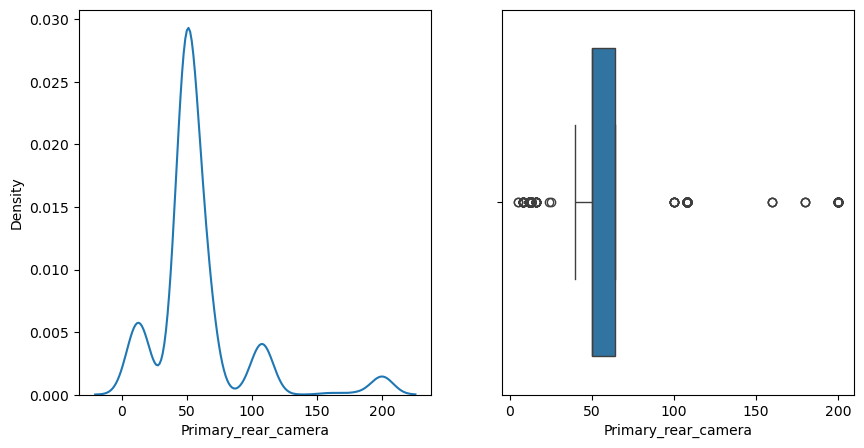

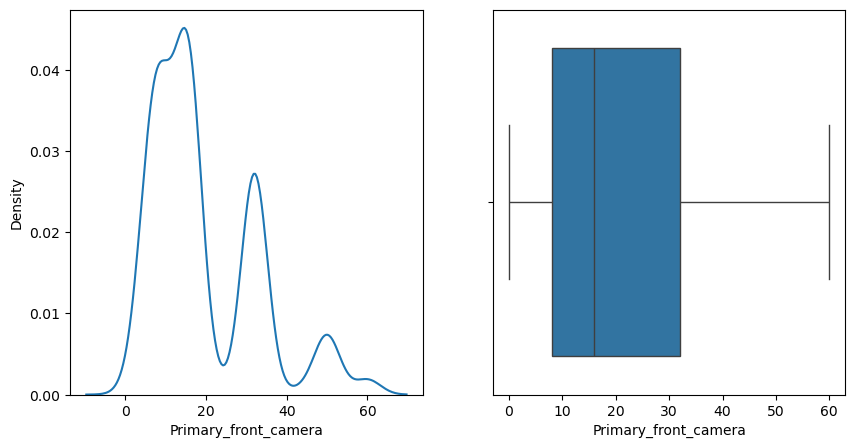

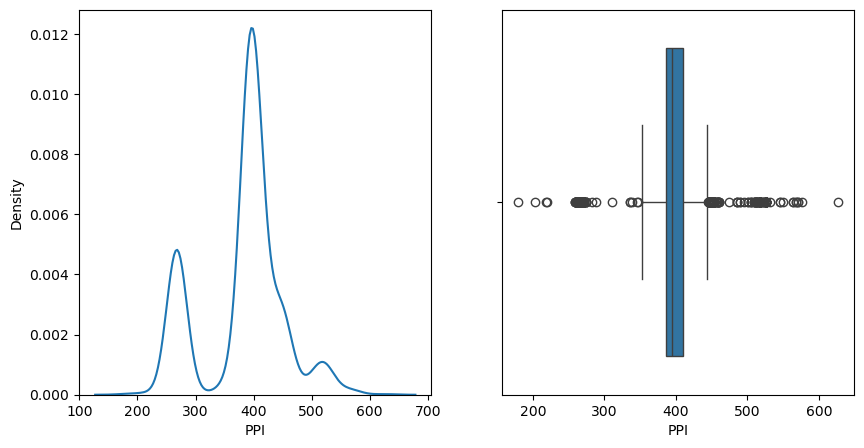

'\nSpec score rigth skewness\nprice and fast charging lift skewness\n'

In [13]:
for i in n_col:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df,x=i)
    plt.subplot(1,2,2)
    sns.boxplot(df,x=i)
    plt.show()

"""
Spec score rigth skewness
price and fast charging lift skewness
"""

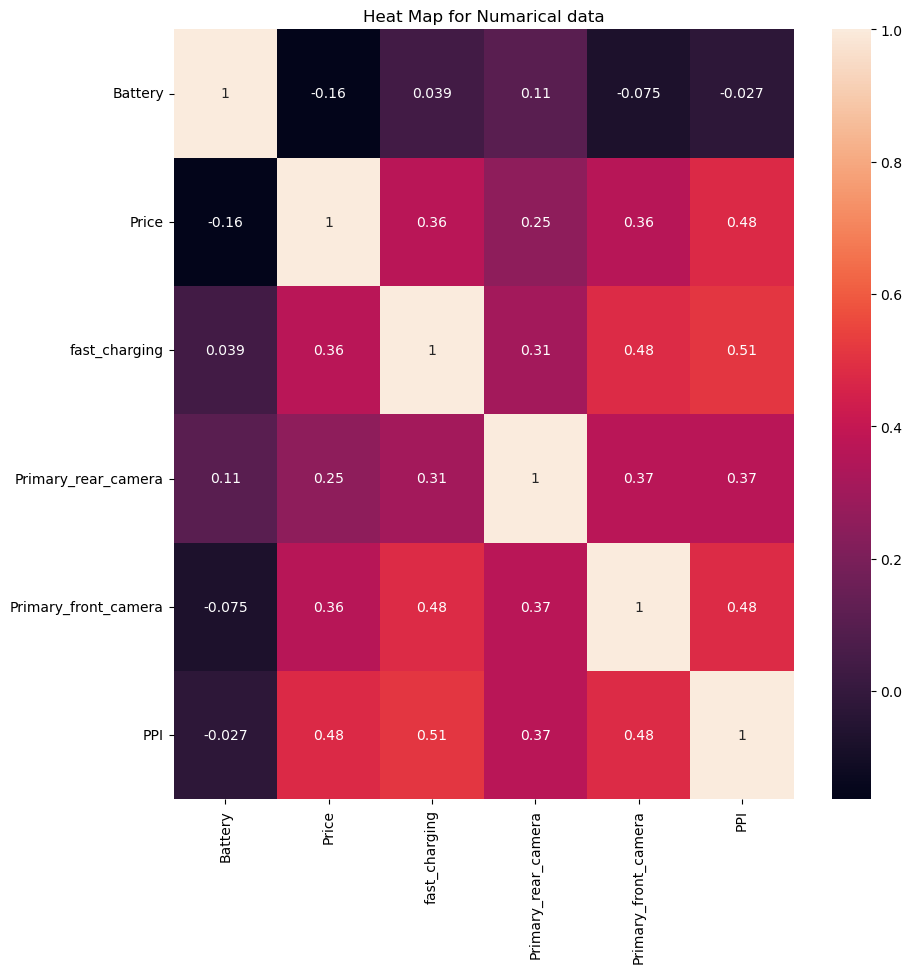

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df[n_col].corr(),annot=True)
plt.title("Heat Map for Numarical data")
plt.show()


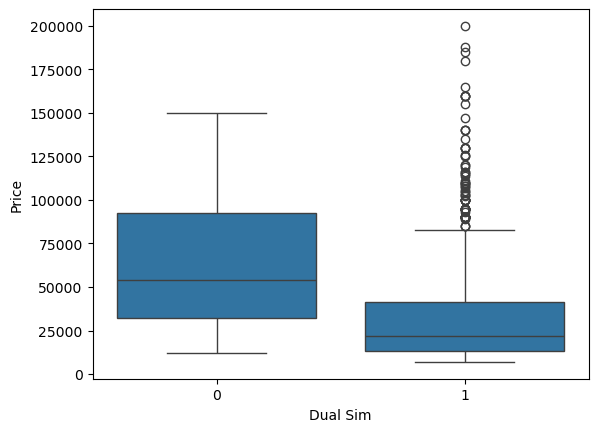

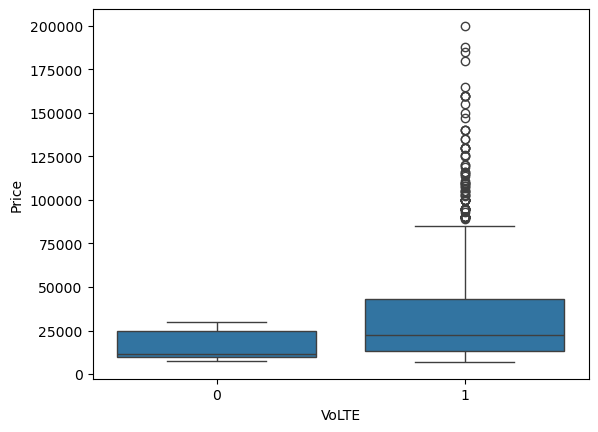

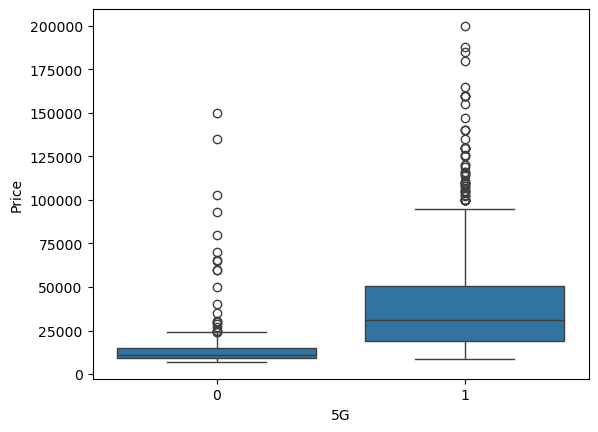

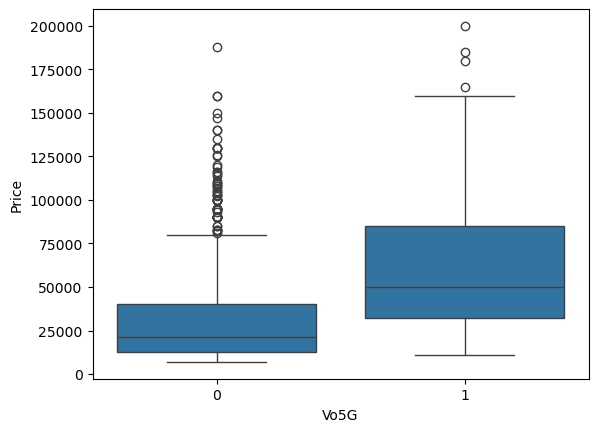

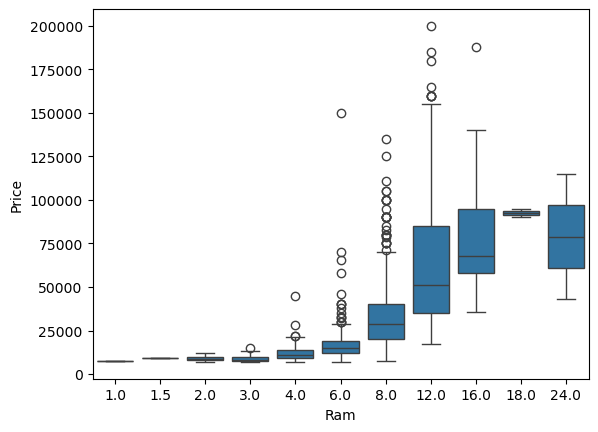

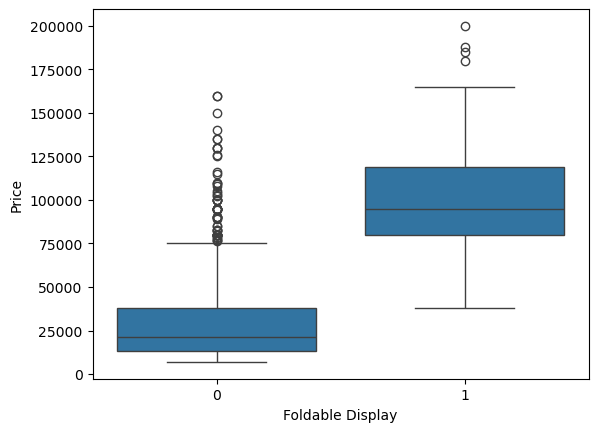

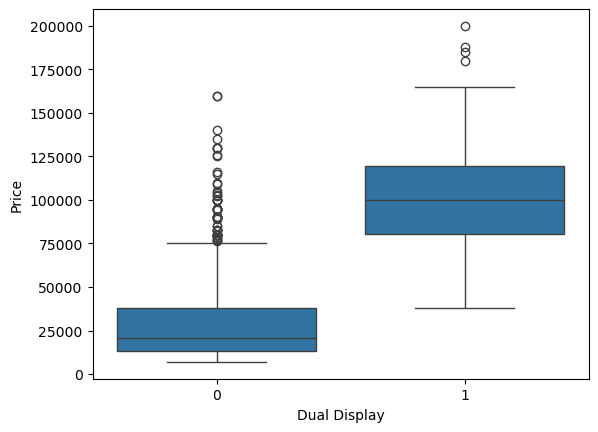

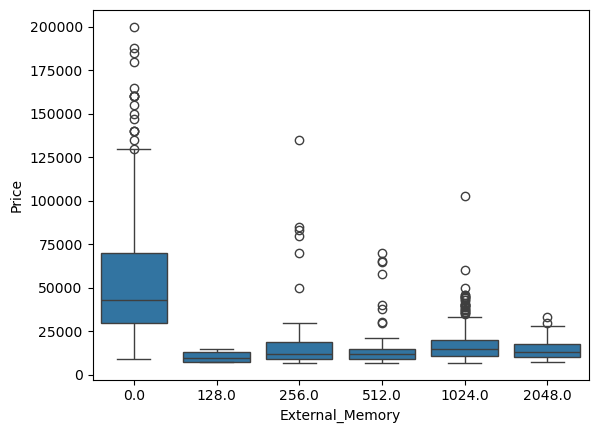

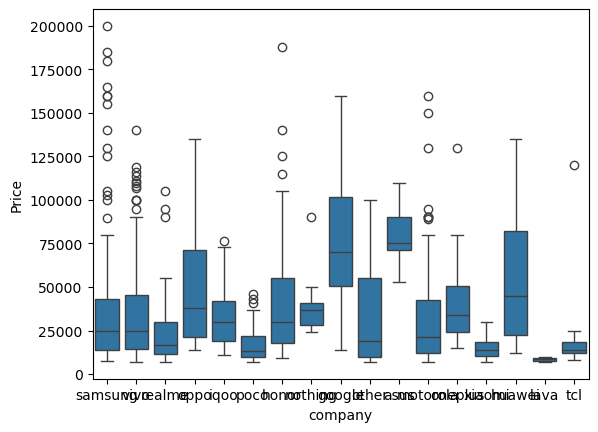

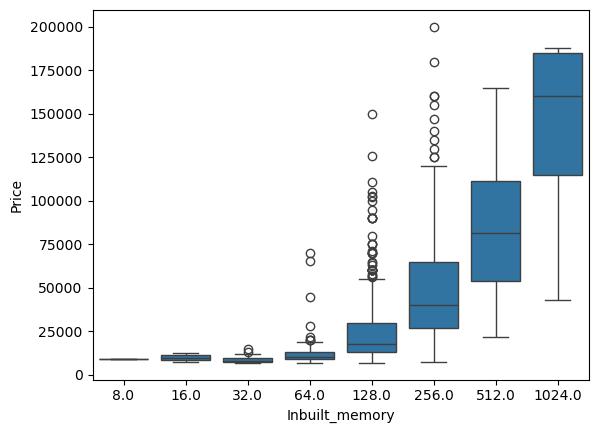

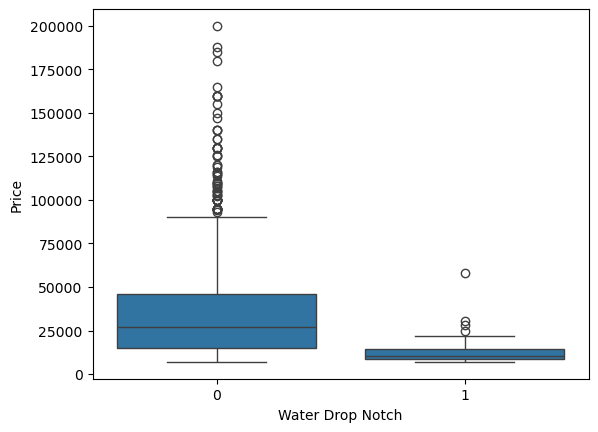

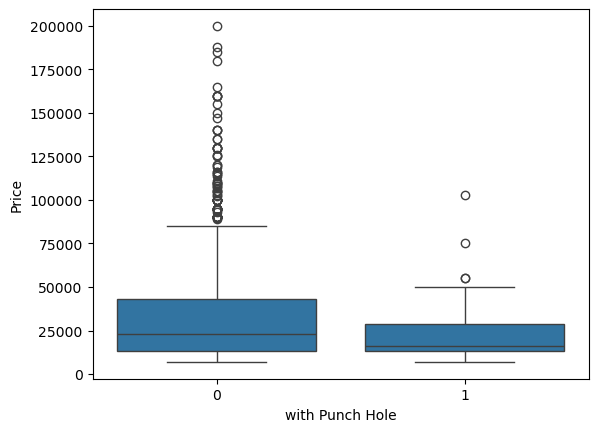

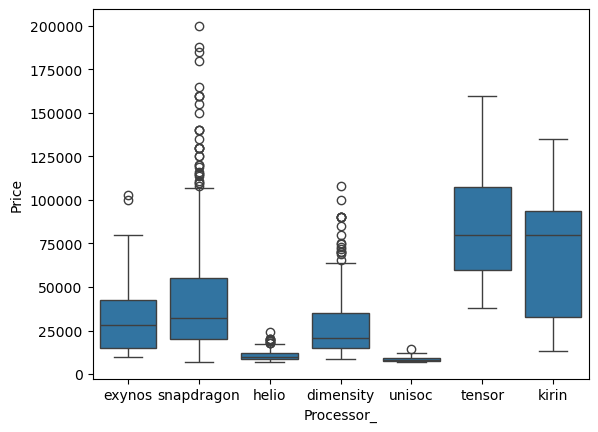

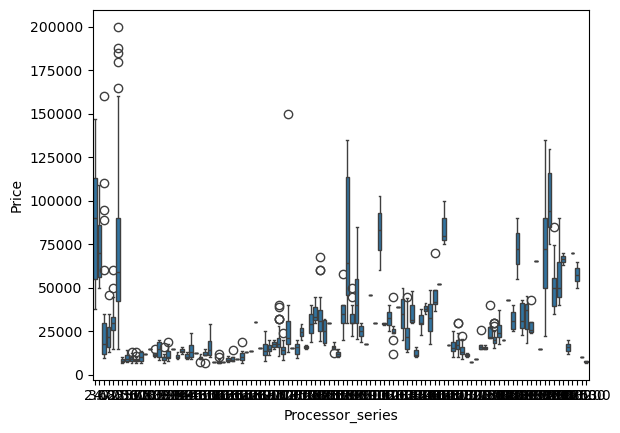

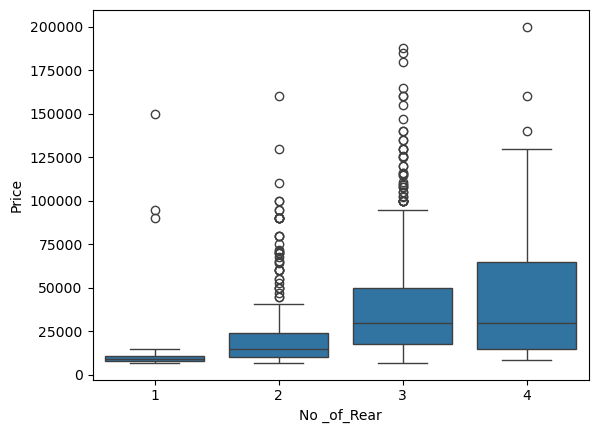

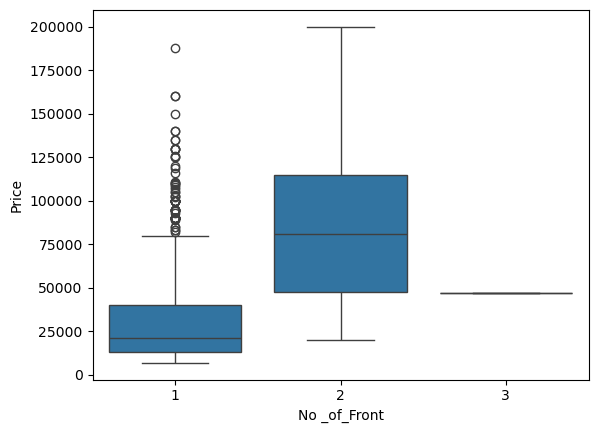

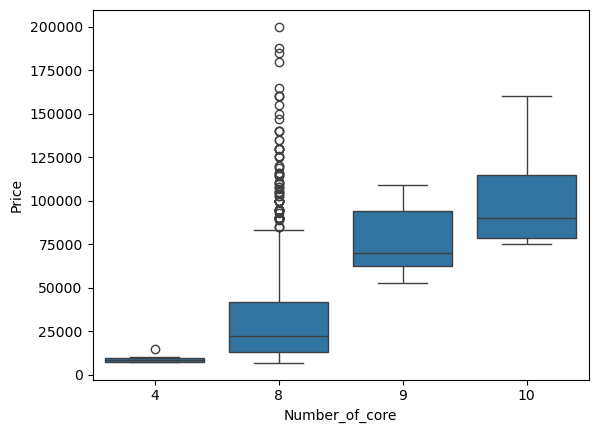

In [15]:
for i in col:
    sns.boxplot(df,y='Price',x=i)
    plt.show()

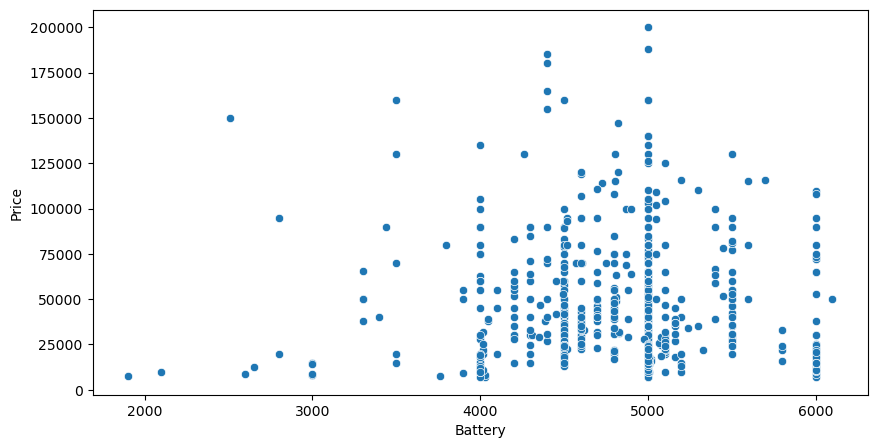

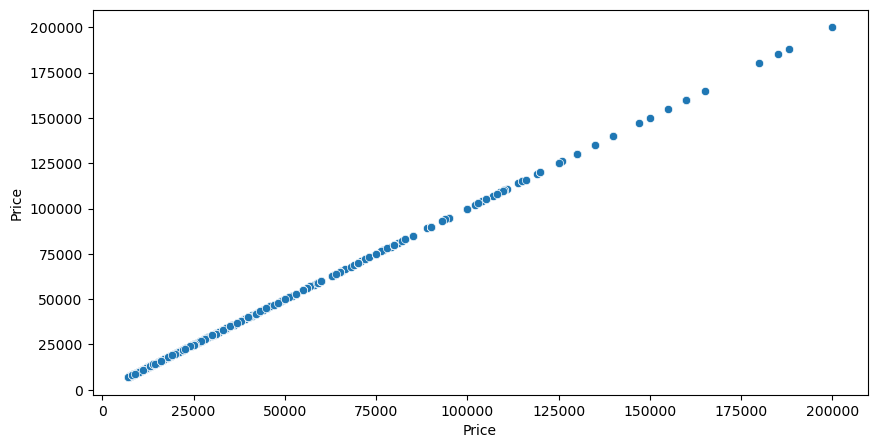

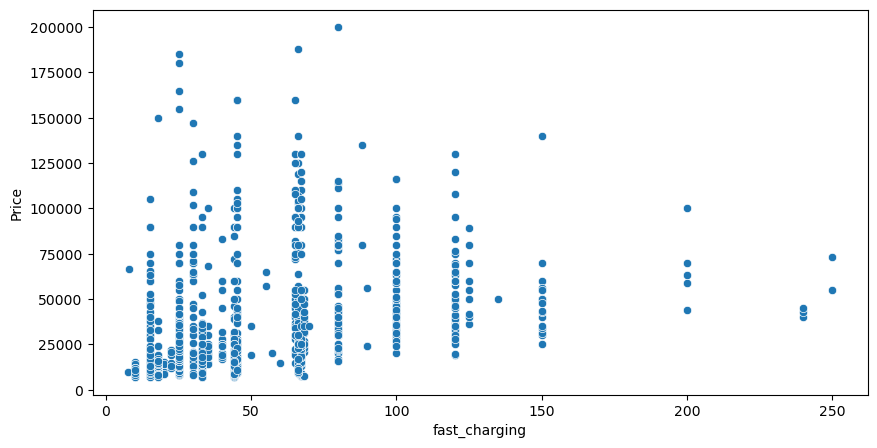

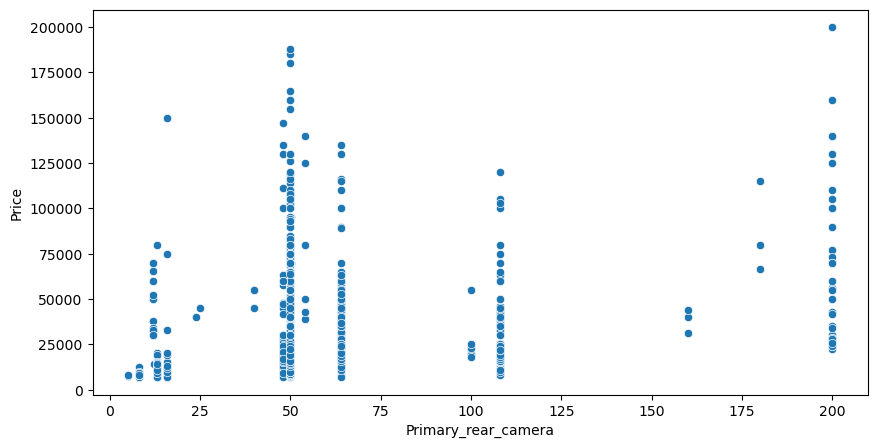

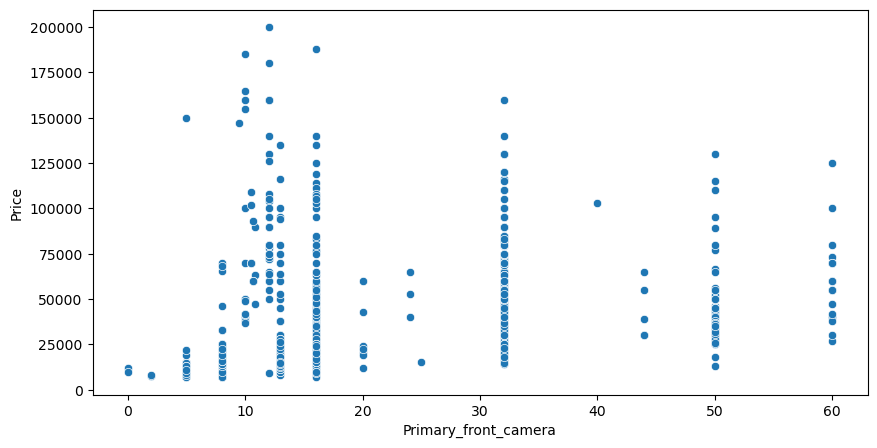

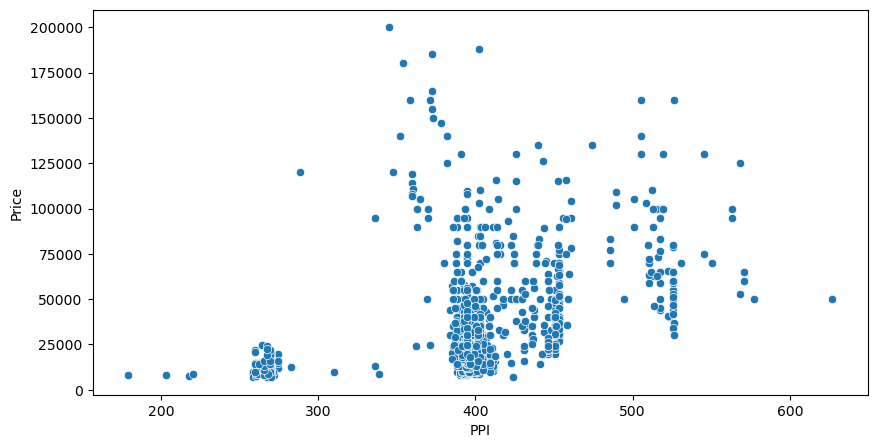

In [16]:
for i in n_col:
    plt.figure(figsize=(10,5))
    sns.scatterplot(df,x=i,y="Price")
    plt.show()


In [17]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
import pickle

In [18]:
x=df.drop('Price',axis=1)
y=np.log(df['Price'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [19]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_'])],remainder='passthrough')
box=ColumnTransformer([('box cox',PowerTransformer(standardize=True),slice(-1))])
poly=PolynomialFeatures(2,interaction_only=True)

In [20]:
lr=LinearRegression()
rl=Ridge(alpha=.9)

In [21]:
pipe=Pipeline([('tranformetion',ct),('add',poly),('box',box),('resression',rl)])
model=pipe.fit(x_train,y_train)

In [22]:
model.score(x_train,y_train)

0.9482816047576446

In [23]:
model.score(x_test,y_test)

0.8713251807567113

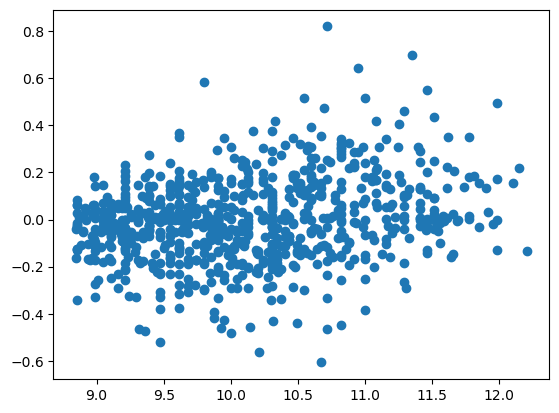

In [24]:
y_pred=model.predict(x_train)
res=y_train-y_pred
plt.scatter(y_train,res)

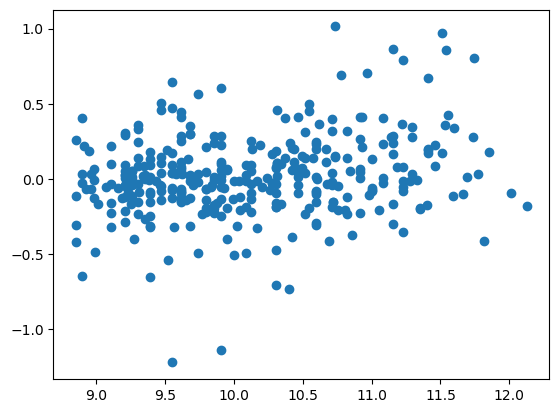

In [25]:
y_pred=model.predict(x_test)
res=y_test-y_pred
plt.scatter(y_test,res)

In [26]:
with open('smart_phone_price.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)


Random forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_'])],remainder='passthrough')

In [29]:
x=df.drop('Price',axis=1)
y=np.log(df['Price'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [30]:
rf=RandomForestRegressor(n_estimators=300,max_features=0.6)

In [31]:
pipe=Pipeline([('tranformetion',ct),('resression',rf)])
model=pipe.fit(x_train,y_train)

In [32]:
model.score(x_train,y_train)

0.9864247638170124

In [33]:
model.score(x_test,y_test)

0.8951428063261051

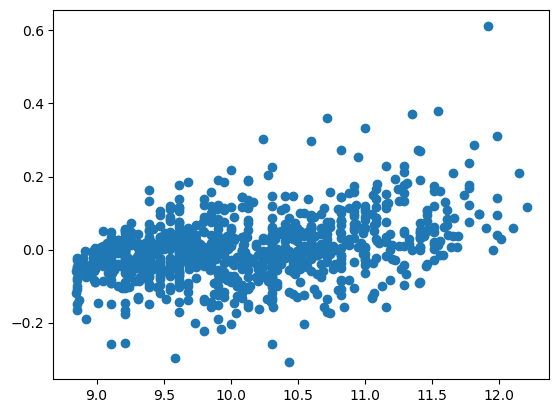

In [34]:
y_pred=model.predict(x_train)
res=y_train-y_pred
plt.scatter(y_train,res)

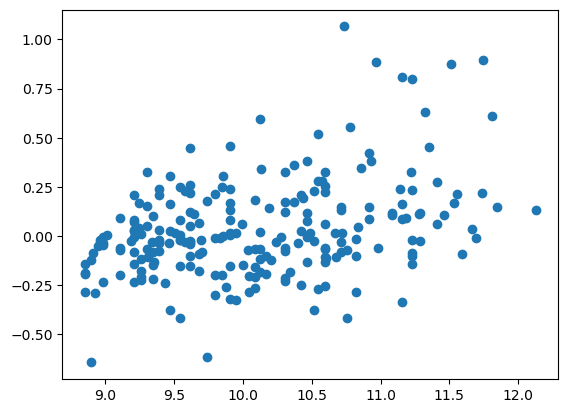

In [35]:
y_pred=model.predict(x_test)
res=y_test-y_pred
plt.scatter(y_test,res)

In [36]:
scores = cross_val_score(model,cv=5,X=x_train,y=y_train)

In [37]:
scores.mean()

0.9013484609364546

In [38]:
with open('smart_phone_price_with_RFR.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)

Deep lreanig

In [1]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import Sequential
from keras.layers import Dense
from keras.metrics import R2Score

In [132]:
x=df.drop('Price',axis=1)
y=df['Price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [136]:
x_train.head(1)

,Dual Sim,VoLTE,5G,Vo5G,Ram,Battery,Foldable Display,Dual Display,External_Memory,company,Inbuilt_memory,fast_charging,Water Drop Notch,with Punch Hole,Processor_,Processor_series,No _of_Rear,No _of_Front,Primary_rear_camera,Primary_front_camera,Number_of_core,PPI
13,1,1,0,0,4.0,5000,0,0,1024.0,samsung,128.0,18.0,0,0,helio,88.0,4,1,48.0,13.0,8,274.146402


In [137]:
x_train.columns.difference(['company', 'Processor_'])

Index(['5G', 'Battery', 'Dual Display', 'Dual Sim', 'External_Memory',
       'Foldable Display', 'Inbuilt_memory', 'No _of_Front', 'No _of_Rear',
       'Number_of_core', 'PPI', 'Primary_front_camera', 'Primary_rear_camera',
       'Processor_series', 'Ram', 'Vo5G', 'VoLTE', 'Water Drop Notch',
       'fast_charging', 'with Punch Hole'],
      dtype='object')

In [138]:
numerical_columns = x_train.columns.difference(['company', 'Processor_'])
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                      ('scaler', StandardScaler(),numerical_columns)],remainder='passthrough')
pipe=Pipeline([('1',ct)])
x_train=pipe.fit_transform(x_train)
x_test=pipe.transform(x_test)

In [152]:
x_test.shape

(228, 42)

In [173]:
model=Sequential()
model.add(Dense(42,activation='relu',input_dim=42))
model.add(Dense(82,activation='relu'))
model.add(Dense(82,activation='relu'))
model.add(Dense(42,activation='relu'))
model.add(Dense(1,activation='linear'))

In [174]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 42)                  │           1,806 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 82)                  │           3,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 82)                  │           6,806 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 42)                  │           3,486 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              43 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,667 (61.20 KB)

 Trainable params: 15,667 (61.20 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model.compile(loss='mse',optimizer='adam')

In [176]:
model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test))

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2006269568.0000 - val_loss: 1960880512.0000
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1993202432.0000 - val_loss: 1947329536.0000
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2224486912.0000 - val_loss: 1835574144.0000
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1762332544.0000 - val_loss: 1331213056.0000
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1211404544.0000 - val_loss: 442422912.0000
Epoch 6/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 384846272.0000 - val_loss: 296619872.0000
Epoch 7/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 269225344.0000 - val_loss: 276414816.0000
Epoch 8/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 254181456.0000 - val_loss: 257453408.0000
Epoch 9/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 244244064.0000 - val_loss: 246978208.0000
Epoch 10/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 218831808.0000 - val_l

In [177]:
ypr=model.predict(x_train)
r2_score(y_train,ypr[:,0])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.9493460833118305

In [178]:
ypr=model.predict(x_test)
r2_score(y_test,ypr[:,0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


0.8153084232858128

In [180]:
tf.config.list_physical_devices('GPU')

[]

,Dual Sim,VoLTE,5G,Vo5G,Ram,Battery,Foldable Display,Dual Display,External_Memory,Price,...,Water Drop Notch,with Punch Hole,Processor_,Processor_series,No _of_Rear,No _of_Front,Primary_rear_camera,Primary_front_camera,Number_of_core,PPI
0,1,1,1,0,4.0,6000,0,0,1024.0,9999,...,1,0,exynos,1330.0,2,1,50.0,13.0,8,399.864072
1,1,1,0,0,2.0,4000,0,0,512.0,9990,...,0,1,snapdragon,450.0,3,1,13.0,8.0,8,268.459145
2,1,1,0,0,4.0,5000,0,0,1024.0,11999,...,1,0,exynos,850.0,4,1,50.0,8.0,8,399.864072
3,1,1,0,0,4.0,6000,0,0,1024.0,11999,...,0,0,helio,88.0,4,1,48.0,13.0,8,274.146402
4,1,1,0,0,4.0,5000,0,0,1024.0,11999,...,1,0,helio,35.0,3,1,13.0,5.0,8,269.928766


In [154]:
x={
        'Dual Sim':[1],'VoLTE':[1],'5G': [1],
        'Vo5G':[1],'Ram':[8],'Battery':[4500],'Foldable Display':[0],
        'company':['google'],'Inbuilt_memory':[128],'fast_charging':[25],
        'Dual Display':[1],'External_Memory':[1024],
        'Water Drop Notch':[1],'with Punch Hole':[0],
        'Processor_':['snapdragon'],'Processor_series':[888],'No _of_Rear':3,'No _of_Front':[1],
        'Primary_rear_camera':[64],'Primary_front_camera':[32],
        'Number_of_core':[8],
        'PPI':[399],
    }
x=pd.DataFrame(x)
x

,Dual Sim,VoLTE,5G,Vo5G,Ram,Battery,Foldable Display,company,Inbuilt_memory,fast_charging,...,Water Drop Notch,with Punch Hole,Processor_,Processor_series,No _of_Rear,No _of_Front,Primary_rear_camera,Primary_front_camera,Number_of_core,PPI
0,1,1,1,1,8,4500,0,google,128,25,...,1,0,snapdragon,888,3,1,64,32,8,399


10.306259543343172